# GRN Mapping
Here we map the filtered individual SNPs onto the GRN 

## Input specifics
1. The matched resutls are in `TF_Match_Results` and `Enhancer_Match_Results`
2. The TF and enhancer coordinates and relations are in the `Data/tables`

## Output speficfics

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

In [2]:
edges = pd.read_table("../../Data/tables/T2.regulome.edges.txt")
nodes = pd.read_table("../../Data/tables/T3.regulome.nodes.txt")
nodes['chrm'] = nodes['chr']
def create_node_to_outgoing_edges_mapping(edges):
    """
    This function takes the edges dataframe as inpupt, and generate a dictionary for the edges of the GRN
    """
    node_to_outgoing_edges = {}
    for index, row in edges.iterrows():
        # Ensure the node entry exists in the dictionary
        if row['from'] not in node_to_outgoing_edges:
            node_to_outgoing_edges[row['from']] = []
        
        # Append the index of the edge to the list of outgoing edges
        node_to_outgoing_edges[row['from']].append(row['to'])
    return node_to_outgoing_edges
grn_map = create_node_to_outgoing_edges_mapping(edges)

## Create a GRN embedding from only TF SNPS

Reduce the time by computing the output in advance

In [44]:
import os
import numpy as np
import pandas as pd
from collections import deque
import pickle

# Function to get all downstream nodes using BFS
def get_all_downstream_nodes(start_node, grn_map):
    downstream_nodes = set([start_node])
    queue = deque([start_node])
    
    while queue:
        node = queue.popleft()
        if node in grn_map:
            for downstream_node in grn_map[node]:
                if downstream_node not in downstream_nodes:
                    downstream_nodes.add(downstream_node)
                    queue.append(downstream_node)
    
    return list(downstream_nodes)

# Trim the the map by removing enhancers with no downstream nodes.
def trim_downstream_map(downstream_map):
    enh_onl_lst = []

    # Identify the keys to delete (i.e., non-enhancer nodes with no downstream nodes)
    for k in downstream_map.keys():
        if k[0] != 'E' and len(downstream_map[k]) == 1:  # Assuming enhancer nodes start with 'E'
            enh_onl_lst.append(k)

    # Remove the identified keys from the downstream map
    for k in enh_onl_lst:
        del downstream_map[k]
    
    return downstream_map

# Precompute downstream nodes for all items in nodes['name']
def precompute_downstream_nodes(nodes, grn_map, output_file):
    downstream_map = {}
    for node in nodes['name']:
        downstream_map[node] = get_all_downstream_nodes(node, grn_map)

    downstream_map = trim_downstream_map(downstream_map)
    # Save the precomputed downstream nodes to a file (pickle)
    with open(output_file, 'wb') as f:
        pickle.dump(downstream_map, f)

    print(f"Precomputed downstream nodes saved to {output_file}")

# Specify the output file path for precomputed results
output_file = '../../Data/Precomputed_Downstream_Nodes.pkl'

# Precompute downstream nodes for all items in the 'name' column of the nodes table
precompute_downstream_nodes(nodes, grn_map, output_file)

Precomputed downstream nodes saved to ../../Data/Precomputed_Downstream_Nodes.pkl


In [45]:
import pickle
def load_precomputed_downstream_nodes(file):
    with open(file, 'rb') as f:
        downstream_map = pickle.load(f)
    return downstream_map

# Load precomputed downstream nodes
downstream_map = load_precomputed_downstream_nodes('../../Data/Precomputed_Downstream_Nodes.pkl')

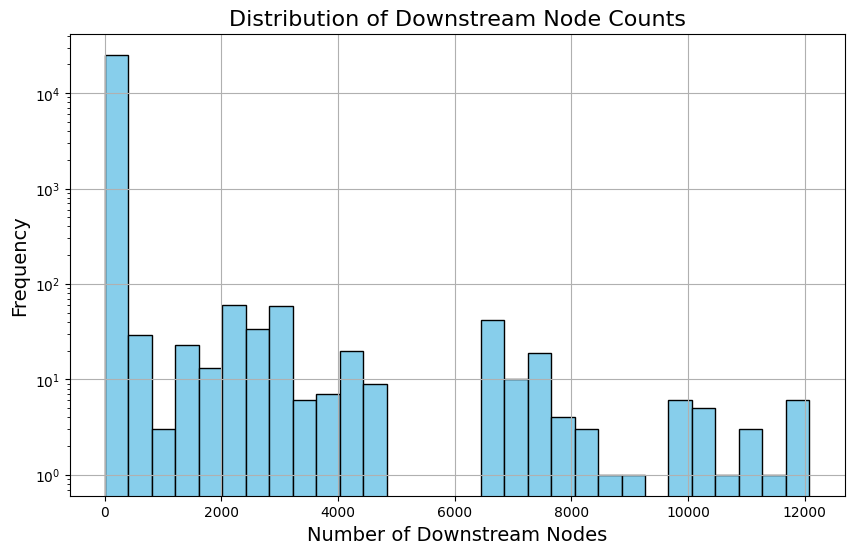

In [57]:
# Generate the histogram data
downstream_lengths = np.array([len(item) for item in downstream_map.values()])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set figure size
plt.hist(downstream_lengths, bins=30, color='skyblue', edgecolor='black')  # Adjust bins and add color

# Add a title and axis labels
plt.title('Distribution of Downstream Node Counts', fontsize=16)
plt.xlabel('Number of Downstream Nodes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')

# Add a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [68]:
import pandas as pd

# Create a list of tuples with each key and the corresponding length of downstream nodes
downstream_data = [(key, len(value)) for key, value in downstream_map.items()]

# Convert the list of tuples into a pandas DataFrame
downstream_df = pd.DataFrame(downstream_data, columns=['Node', 'Downstream_Size'])
downstream_df.set_index('Node', inplace=True)

# Display the first few rows of the DataFrame
downstream_df[downstream_df['Downstream_Size'] >= 5000]

,Downstream_Size
Node,
71181,10077
144995,12080
145283,12080
145288,12080
145291,12080
...,...
ENSG00000126003.7,7530
ENSG00000101412.13,6961
ENSG00000101126.18,6586


In [69]:
import numpy as np
file_path = "../../Data/TF_Match_Results/tf_matched_SS0012978.bed"
df = pd.read_csv(file_path, sep='\t', header=None, names=['TF'],usecols=[8])
row = df.iloc[0]
tf_node = row['TF']
individual_vector = np.zeros(N, dtype=int)

In [70]:
for tf_node in df['TF'].unique():
    if tf_node in downstream_map:
        downstream_indices = [node_to_index[node] for node in downstream_map[tf_node] if node in node_to_index]
        individual_vector[downstream_indices] = 1  # Mark affected nodes
individual_vector

array([0, 1, 0, ..., 1, 1, 0])

In [73]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

# Load the precomputed downstream nodes from file
def load_precomputed_downstream_nodes(file):
    with open(file, 'rb') as f:
        downstream_map = pickle.load(f)
    return downstream_map

# Load precomputed downstream nodes
downstream_map = load_precomputed_downstream_nodes('../../Data/Precomputed_Downstream_Nodes.pkl')

# Define the GRN map and node list
all_nodes = nodes['name'].tolist()
N = len(all_nodes)
node_to_index = {node: idx for idx, node in enumerate(all_nodes)}

# Function to process a batch of files and generate embeddings
def process_batch(batch_files, batch_number, tf_match_results_dir, output_dir):
    tf_embeddings = {}  # Initialize embeddings dictionary for this batch

    with tqdm(total=len(batch_files), desc=f"Processing Batch {batch_number}") as pbar:
        for file in batch_files:
            individual_id = file.split('_')[2]  # Assuming file names have individual IDs
            individual_vector = np.zeros(N, dtype=int)

            # Load the matching results for this individual
            file_path = os.path.join(tf_match_results_dir, file)
            df = pd.read_csv(file_path, sep='\t', header=None, names=['TF'], usecols=[8])

            # Get the precomputed downstream nodes for each TF node and mark them
            for tf_node in df['TF'].unique():
                if tf_node in downstream_map:
                    downstream_indices = [node_to_index[node] for node in downstream_map[tf_node] if node in node_to_index]
                    individual_vector[downstream_indices] = 1  # Mark affected nodes

            # Store the embedding for this individual
            tf_embeddings[individual_id] = individual_vector

            # Update the progress bar
            pbar.update(1)

    # Convert the batch embeddings to a DataFrame and save the results
    tf_embeddings_df = pd.DataFrame.from_dict(tf_embeddings, orient='index', columns=all_nodes)
    batch_output_file = os.path.join(output_dir, f'tf_embeddings_batch_{batch_number}.csv')
    tf_embeddings_df.to_csv(batch_output_file)

    print(f"Batch {batch_number} saved to {batch_output_file}")

# Load and process the TF_Match_Results folder
tf_match_results_dir = "../../Data/TF_Match_Results"
tf_files = [file for file in os.listdir(tf_match_results_dir) if file.endswith(".bed")]

# Process the files in batches of 128
batch_size = 128
num_batches = len(tf_files) // batch_size + (1 if len(tf_files) % batch_size != 0 else 0)

# Create output directory if it doesn't exist
output_dir = '../../Data/TF_Embeddings'
os.makedirs(output_dir, exist_ok=True)

for batch_num in range(num_batches):
    start_index = batch_num * batch_size
    end_index = min(start_index + batch_size, len(tf_files))
    batch_files = tf_files[start_index:end_index]

    # Process the current batch of files and save after each batch
    process_batch(batch_files, batch_num + 1, tf_match_results_dir, output_dir)

print("All batches have been processed and saved.")


Processing Batch 1: 100%|█████████████████████| 128/128 [00:09<00:00, 13.84it/s]


Batch 1 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_1.csv


Processing Batch 2: 100%|█████████████████████| 128/128 [00:10<00:00, 12.51it/s]


Batch 2 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_2.csv


Processing Batch 3: 100%|█████████████████████| 128/128 [00:10<00:00, 12.43it/s]


Batch 3 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_3.csv


Processing Batch 4: 100%|█████████████████████| 128/128 [00:10<00:00, 12.63it/s]


Batch 4 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_4.csv


Processing Batch 5: 100%|█████████████████████| 128/128 [00:10<00:00, 12.65it/s]


Batch 5 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_5.csv


Processing Batch 6: 100%|█████████████████████| 128/128 [00:10<00:00, 12.59it/s]


Batch 6 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_6.csv


Processing Batch 7: 100%|█████████████████████| 128/128 [00:10<00:00, 12.59it/s]


Batch 7 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_7.csv


Processing Batch 8: 100%|█████████████████████| 128/128 [00:10<00:00, 12.46it/s]


Batch 8 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_8.csv


Processing Batch 9: 100%|█████████████████████| 128/128 [00:10<00:00, 12.29it/s]


Batch 9 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_9.csv


Processing Batch 10: 100%|████████████████████| 128/128 [00:10<00:00, 12.68it/s]


Batch 10 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_10.csv


Processing Batch 11: 100%|████████████████████| 128/128 [00:10<00:00, 12.64it/s]


Batch 11 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_11.csv


Processing Batch 12: 100%|████████████████████| 128/128 [00:10<00:00, 12.71it/s]


Batch 12 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_12.csv


Processing Batch 13: 100%|████████████████████| 128/128 [00:09<00:00, 12.81it/s]


Batch 13 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_13.csv


Processing Batch 14: 100%|████████████████████| 128/128 [00:10<00:00, 12.58it/s]


Batch 14 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_14.csv


Processing Batch 15: 100%|████████████████████| 128/128 [00:10<00:00, 12.75it/s]


Batch 15 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_15.csv


Processing Batch 16: 100%|████████████████████| 128/128 [00:10<00:00, 12.73it/s]


Batch 16 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_16.csv


Processing Batch 17: 100%|████████████████████| 128/128 [00:10<00:00, 12.65it/s]


Batch 17 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_17.csv


Processing Batch 18: 100%|████████████████████| 128/128 [00:10<00:00, 12.78it/s]


Batch 18 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_18.csv


Processing Batch 19: 100%|████████████████████| 128/128 [00:10<00:00, 12.52it/s]


Batch 19 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_19.csv


Processing Batch 20: 100%|██████████████████████| 26/26 [00:02<00:00, 12.70it/s]


Batch 20 saved to ../../Data/TF_Embeddings/tf_embeddings_batch_20.csv
All batches have been processed and saved.


In [65]:
# Load the GRN_Enhancer_match_SNP.bed
grn_enhancer_snp = pd.read_csv('../../Data/GRN_Enhancer_matched_SNP.bed', sep='\t', 
                               names=['chrm', 'start', 'end', 'alt', 'ref'])

# Load the matched_SNPs_Enhancer_nodes.bed, which contains the enhancer node names
matched_snp_enhancer_nodes = pd.read_csv('../../Data/matched_SNPs_Enhancer_nodes.bed', sep='\t', 
                                         names=['chrm', 'start', 'end', 'alt', 'ref', 'Enhancer'], usecols=[0,1,2,3,4,9])

matched_snp_enhancer_nodes['Enhancer'] = matched_snp_enhancer_nodes['Enhancer'].astype(str)

# Merge the two DataFrames on the shared columns (chrm, start, end, alt, ref)
enhancer_snp_with_nodes = pd.merge(grn_enhancer_snp, matched_snp_enhancer_nodes, 
                                   on=['chrm', 'start', 'end', 'alt', 'ref'], how='inner')

# Now 'enhancer_snp_with_nodes' contains the 'Enhancer' column
print(enhancer_snp_with_nodes.head())

# Save the updated DataFrame back to a new file
enhancer_snp_with_nodes.to_csv('../../Data/GRN_Enhancer_with_Nodes.bed', sep='\t', index=False)


   chrm   start     end alt ref Enhancer
0  chr1  937048  937049   G   A       35
1  chr1  944063  944064   G   A       37
2  chr1  944170  944171   G   C       37
3  chr1  944172  944173   G   A       37
4  chr1  944177  944178   C   T       37


In [75]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load the precomputed downstream nodes from file
def load_precomputed_downstream_nodes(file):
    with open(file, 'rb') as f:
        downstream_map = pickle.load(f)
    return downstream_map

# Load precomputed downstream nodes
downstream_map = load_precomputed_downstream_nodes('../../Data/Precomputed_Downstream_Nodes.pkl')

# Load the GRN_Enhancer_match_SNP.bed file as a DataFrame
grn_enhancer_snp_df = pd.read_csv('../../Data/GRN_Enhancer_with_Nodes.bed', sep='\t', 
                                  names=['chrm', 'start', 'end', 'ref', 'alt', 'Enhancer'],header=0)
grn_enhancer_snp_df['Enhancer'] = grn_enhancer_snp_df['Enhancer'].astype(str)

# Define the GRN map and node list
all_nodes = nodes['name'].tolist()
N = len(all_nodes)
node_to_index = {node: idx for idx, node in enumerate(all_nodes)}

# Function to match enhancer bed files with GRN_Enhancer_match_SNP.bed and generate embeddings
def process_enhancer_batch(batch_files, batch_number, enhancer_match_results_dir, enhancer_embeddings, output_dir):
    enhancer_embeddings = {}  # Initialize embeddings dictionary for this batch
    
    with tqdm(total=len(batch_files), desc=f"Processing Enhancer Batch {batch_number}") as pbar:
        for file in batch_files:
            individual_id = file.split('_')[2]  # Assuming file names have individual IDs
            individual_vector = np.zeros(N, dtype=int)

            # Load the enhancer bed file for this individual
            file_path = os.path.join(enhancer_match_results_dir, file)
            df = pd.read_csv(file_path, sep='\t', header=None, names=['chrm', 'start', 'end', 'ref', 'alt'], usecols=[0,1,2,3,4])

            # Perform exact match with GRN_Enhancer_match_SNP.bed based on chromosome, start, end, ref, alt
            matched_nodes = pd.merge(df, grn_enhancer_snp_df, on=['chrm', 'start', 'end', 'ref', 'alt'], how='inner')

            # Get the precomputed downstream nodes for each matched enhancer node and mark them
            for enhancer_node in matched_nodes['Enhancer'].unique():
                if enhancer_node in downstream_map:
                    downstream_indices = [node_to_index[node] for node in downstream_map[enhancer_node] if node in node_to_index]
                    individual_vector[downstream_indices] = 1  # Mark affected nodes

            # Store the embedding for this individual
            enhancer_embeddings[individual_id] = individual_vector

            # Update the progress bar
            pbar.update(1)

    # Convert the batch embeddings to a DataFrame and save the results
    enhancer_embeddings_df = pd.DataFrame.from_dict(enhancer_embeddings, orient='index', columns=all_nodes)
    batch_output_file = os.path.join(output_dir, f'enhancer_embeddings_batch_{batch_number}.csv')
    enhancer_embeddings_df.to_csv(batch_output_file)

    print(f"Enhancer Batch {batch_number} saved to {batch_output_file}")

# Load and process the Enhancer_Match_Results folder
enhancer_match_results_dir = "../../Data/Enhancer_Match_Results"
enhancer_files = [file for file in os.listdir(enhancer_match_results_dir) if file.endswith(".bed")]

# Process the files in batches of 128
batch_size = 128
num_batches = len(enhancer_files) // batch_size + (1 if len(enhancer_files) % batch_size != 0 else 0)

# Create output directory if it doesn't exist
output_dir = '../../Data/Enhancer_Embeddings'
os.makedirs(output_dir, exist_ok=True)

# Initialize dictionary to store embeddings for each individual
enhancer_embeddings = {}

for batch_num in range(num_batches):
    start_index = batch_num * batch_size
    end_index = min(start_index + batch_size, len(enhancer_files))
    batch_files = enhancer_files[start_index:end_index]

    # Process the current batch of files and save after each batch
    process_enhancer_batch(batch_files, batch_num + 1, enhancer_match_results_dir, enhancer_embeddings, output_dir)

print("All enhancer batches have been processed and saved.")


Processing Enhancer Batch 1: 100%|████████████| 128/128 [00:03<00:00, 40.61it/s]


Enhancer Batch 1 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_1.csv


Processing Enhancer Batch 2: 100%|████████████| 128/128 [00:02<00:00, 50.06it/s]


Enhancer Batch 2 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_2.csv


Processing Enhancer Batch 3: 100%|████████████| 128/128 [00:02<00:00, 49.63it/s]


Enhancer Batch 3 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_3.csv


Processing Enhancer Batch 4: 100%|████████████| 128/128 [00:02<00:00, 49.90it/s]


Enhancer Batch 4 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_4.csv


Processing Enhancer Batch 5: 100%|████████████| 128/128 [00:02<00:00, 48.23it/s]


Enhancer Batch 5 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_5.csv


Processing Enhancer Batch 6: 100%|████████████| 128/128 [00:02<00:00, 49.28it/s]


Enhancer Batch 6 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_6.csv


Processing Enhancer Batch 7: 100%|████████████| 128/128 [00:02<00:00, 50.10it/s]


Enhancer Batch 7 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_7.csv


Processing Enhancer Batch 8: 100%|████████████| 128/128 [00:02<00:00, 48.97it/s]


Enhancer Batch 8 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_8.csv


Processing Enhancer Batch 9: 100%|████████████| 128/128 [00:02<00:00, 50.20it/s]


Enhancer Batch 9 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_9.csv


Processing Enhancer Batch 10: 100%|███████████| 128/128 [00:02<00:00, 51.08it/s]


Enhancer Batch 10 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_10.csv


Processing Enhancer Batch 11: 100%|███████████| 128/128 [00:02<00:00, 51.48it/s]


Enhancer Batch 11 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_11.csv


Processing Enhancer Batch 12: 100%|███████████| 128/128 [00:02<00:00, 49.99it/s]


Enhancer Batch 12 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_12.csv


Processing Enhancer Batch 13: 100%|███████████| 128/128 [00:02<00:00, 49.42it/s]


Enhancer Batch 13 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_13.csv


Processing Enhancer Batch 14: 100%|███████████| 128/128 [00:02<00:00, 51.12it/s]


Enhancer Batch 14 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_14.csv


Processing Enhancer Batch 15: 100%|███████████| 128/128 [00:02<00:00, 52.34it/s]


Enhancer Batch 15 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_15.csv


Processing Enhancer Batch 16: 100%|███████████| 128/128 [00:01<00:00, 71.26it/s]


Enhancer Batch 16 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_16.csv


Processing Enhancer Batch 17: 100%|███████████| 128/128 [00:01<00:00, 73.54it/s]


Enhancer Batch 17 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_17.csv


Processing Enhancer Batch 18: 100%|███████████| 128/128 [00:01<00:00, 74.21it/s]


Enhancer Batch 18 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_18.csv


Processing Enhancer Batch 19: 100%|███████████| 128/128 [00:02<00:00, 51.05it/s]


Enhancer Batch 19 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_19.csv


Processing Enhancer Batch 20: 100%|█████████████| 26/26 [00:00<00:00, 47.64it/s]


Enhancer Batch 20 saved to ../../Data/Enhancer_Embeddings/enhancer_embeddings_batch_20.csv
All enhancer batches have been processed and saved.


In [72]:
nodes['node_type'].unique()

array(['enhancer', 'lncRNA', 'protein_coding', 'TF'], dtype=object)